In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [16]:
fname               = 'F25'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 100
batch_size_second   = 500
evaluate_num        = 16
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, evaluate_dic_list, **kwargs):
        super(net_test, self).__init__()
        self.hw_layer = hw_layer(evaluate_dic_list)
        self.hw_dims = self.hw_layer.channels
        self.conv1d = torch.nn.Conv1d(self.hw_layer.channels, self.hw_dims, 5, 1, 2, bias=False)
        self.lstm1 = torch.nn.LSTM(self.hw_dims, self.hw_dims//2, bias=False, bidirectional=True, batch_first=True)
        self.lstm2 = torch.nn.LSTM(self.hw_dims, self.hw_dims//2, bias=False, bidirectional=True, batch_first=True)
        self.lstm3 = torch.nn.LSTM(self.hw_dims, self.hw_dims//2, bias=False, bidirectional=True, batch_first=True)
        self.fc1 = torch.nn.Linear(self.hw_dims, 32, bias=False)
        self.selu = torch.nn.SELU()
        self.fc2 = torch.nn.Linear(32, 1, bias=True)
    def forward(self, x):
        hw = self.hw_layer(x)
        #lstm1
        x, _ = self.lstm1(hw)
        x = x * hw
        #lstm2
        x, _ = self.lstm2(x)
        x = x * hw
        #lstm3
        x, _ = self.lstm3(x)
        x = x * hw
        #fc1
        x = self.fc1(x)
        x = self.selu(x)
        #fc2
        x = self.fc2(x)
        return x

In [4]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

In [5]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [6]:
data_train_df = add_features(data_train_df)
data_test_df = add_features(data_test_df)

In [7]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [8]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [9]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [10]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [11]:
del data_train_df
del data_test_df
gc.collect()

0

In [12]:
evaluate_list = [evaluate_build(x_test[..., i], evaluate_num) for i in range(x_test.shape[-1])]
evaluate_focus_list = []
for evaluate in evaluate_list:
    focus = 1 - (len(evaluate) - 1)/10
    if focus < focus_min:
        focus = focus_min
    evaluate_focus = focus_build(evaluate, focus)
    evaluate_focus_list.append(evaluate_focus)

evaluate_num:  16,focus:0.6000: 16it [00:00, 15993.53it/s]
evaluate_num:  13,focus:0.6000: 13it [00:00, 6498.15it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:  16,focus:0.6000: 16it [00:00, 3999.57it/s]
evaluate_num:   8,focus:0.6000: 8it [00:00, ?it/s]
evaluate_num:  11,focus:0.6000: 11it [00:00, 11042.93it/s]
evaluate_num:  16,focus:0.6000: 16it [00:00, 7997.72it/s]
evaluate_num:  16,focus:0.6000: 16it [00:00, 2285.18it/s]
evaluate_num:  13,focus:0.6000: 13it [00:00, 3248.88it/s]
evaluate_num:  13,focus:0.6000: 13it [00:00, 4331.93it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, 1999.67it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, 2002.53it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]
evaluate_num

In [13]:
model = net_test(evaluate_focus_list)
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(16, 1)
      (1): Embedding(13, 1)
      (2): Embedding(2, 1)
      (3): Embedding(16, 1)
      (4): Embedding(8, 1)
      (5): Embedding(11, 1)
      (6): Embedding(16, 1)
      (7): Embedding(16, 1)
      (8): Embedding(13, 1)
      (9): Embedding(13, 1)
      (10): Embedding(2, 1)
      (11): Embedding(2, 1)
      (12): Embedding(2, 1)
      (13): Embedding(2, 1)
      (14): Embedding(2, 1)
      (15): Embedding(2, 1)
      (16): Embedding(2, 1)
      (17): Embedding(2, 1)
      (18): Embedding(2, 1)
      (19): Embedding(2, 1)
      (20): Embedding(2, 1)
      (21): Embedding(2, 1)
      (22): Embedding(2, 1)
      (23): Embedding(2, 1)
      (24): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(16, 1)
      (1): Embedding(13, 1)
      (2): Embedding(2, 1)
      (3): Embedding(16, 1)
      (4): Embedding(8, 1)
      (5): Embedding(11, 1)
      (6): Embedding(16, 1)
     

epoch,train_loss,valid_loss,time
0,5.748577,5.333318,00:18
1,4.387422,4.242223,00:18
2,2.004884,1.888853,00:18
3,1.082551,1.068494,00:18
4,0.916900,0.912480,00:18
5,0.840148,0.843568,00:18
6,0.755515,0.751834,00:18
7,0.696206,0.702269,00:18
8,0.671443,0.661813,00:18
9,0.633763,0.625577,00:18


Epoch 21: reducing lr to 0.00019325118810697967
Epoch 31: reducing lr to 0.00019573399534633722
Epoch 41: reducing lr to 0.00017570428009771845
Epoch 51: reducing lr to 0.00014258476813180866
Epoch 61: reducing lr to 0.00010210215519573568
Epoch 71: reducing lr to 6.125621637808663e-05
Epoch 81: reducing lr to 2.710962402678466e-05
Epoch 91: reducing lr to 5.56658787633068e-06


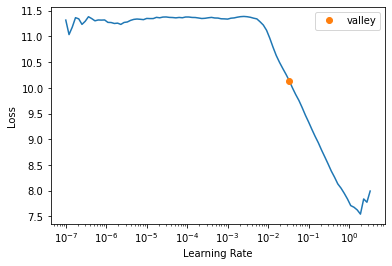

In [14]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

epoch,train_loss,valid_loss,time
0,0.257855,0.297612,00:12
1,0.258167,0.297641,00:12
2,0.258158,0.297657,00:12
3,0.258693,0.298210,00:12
4,0.258723,0.298059,00:12
5,0.260597,0.299186,00:12
6,0.260538,0.299413,00:12
7,0.261185,0.298598,00:12
8,0.262372,0.299637,00:13
9,0.263984,0.303718,00:12


Better model found at epoch 0 with valid_loss value: 0.29761168360710144.
Epoch 10: reducing lr to 8.591347194839051e-05
Epoch 20: reducing lr to 0.00018807736282679062
Epoch 30: reducing lr to 0.00019686695046697975
Epoch 40: reducing lr to 0.0001783910593204253
Better model found at epoch 41 with valid_loss value: 0.2975044846534729.
Better model found at epoch 45 with valid_loss value: 0.29687297344207764.
Better model found at epoch 49 with valid_loss value: 0.2945927083492279.
Epoch 50: reducing lr to 0.00014636080449597928
Better model found at epoch 54 with valid_loss value: 0.2942572236061096.
Better model found at epoch 56 with valid_loss value: 0.2933761477470398.
Better model found at epoch 59 with valid_loss value: 0.29298925399780273.
Better model found at epoch 60 with valid_loss value: 0.29134902358055115.
Epoch 60: reducing lr to 0.00010631454665746575
Better model found at epoch 62 with valid_loss value: 0.290539026260376.
Better model found at epoch 66 with valid_loss

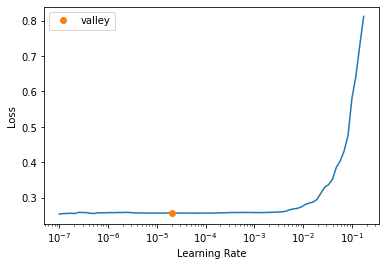

In [17]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [18]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.2289663538459904 0.2840997201781119


In [19]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 101/101 [00:03<00:00, 30.97it/s]


In [ ]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')